## Chapter 14 Practice Activites (7.2)

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from plotnine import *

In [2]:
ames = pd.read_csv(r"C:\Users\broga\OneDrive\Desktop\MSBA\Computing_ML\In_class\Week_7\AmesHousing.csv")

In [3]:
#Clean
# Get rid of columns with mostly NaN values
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]

# Drop other NAs
ames = ames.dropna()

X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]

## PA 1

In [4]:
#Create Pipeline

ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)), #object is pandas word for str or cat var
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number)) #designates quantitative
  ],
  remainder = "passthrough"
)

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())
   ]
)

#calc r^2 with cv
cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = 'r2')

array([-4.81567121e+21, -2.38163240e+21, -4.34197558e+22, -7.28788907e+22,
       -8.12115046e+20])

In [5]:
#Ridge Regression
ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)), #object is pandas word for str or cat var
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number)) #designates quantitative
  ],
  remainder = "passthrough"
)

ridge_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=1))]
)
#calc r^2 with cv on pipe 2
cross_val_score(ridge_pipeline, X, y, cv = 5, scoring = 'r2')


array([0.8983804 , 0.91749817, 0.79251623, 0.78248152, 0.91492025])

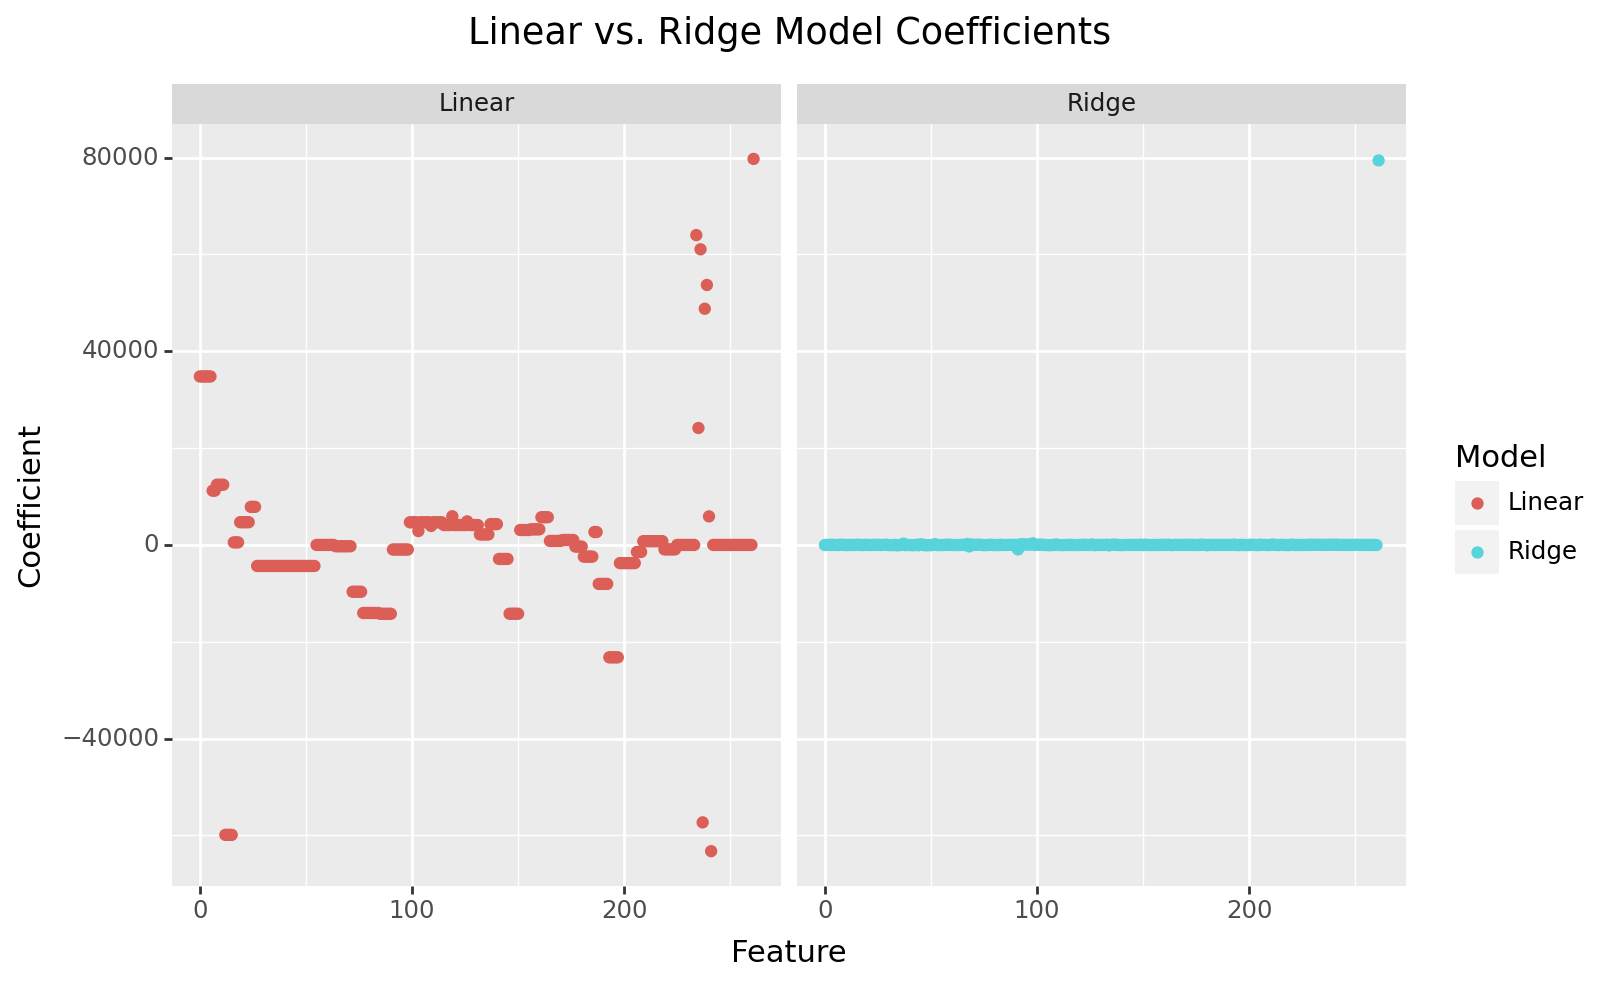

In [6]:
#Fit both on entire df
lr_pipeline_1.fit(ames, y)
ridge_pipeline.fit(ames, y)
#Get coefficients
linear_coefs = lr_pipeline_1.named_steps['linear_regression'].coef_
ridge_coefs = ridge_pipeline.named_steps['ridge_regression'].coef_

coefs_df = pd.DataFrame({
    'Coefficient': np.concatenate((ridge_coefs, linear_coefs)),
    'Model': ['Ridge'] * len(ridge_coefs) + ['Linear'] * len(linear_coefs),
    'Feature': list(range(len(ridge_coefs))) + list(range(len(linear_coefs)))
})

coefs_plot = (ggplot(coefs_df, aes(x='Feature', y='Coefficient', color='Model'))
    + geom_point()
    + labs(x='Feature', y='Coefficient', title='Linear vs. Ridge Model Coefficients')
    + theme(plot_title=element_text(ha='center'), figure_size=(8, 5))
    + facet_wrap('Model'))

print(coefs_plot)

## PA 2

In [7]:
#Gridsearch csv Ridge Regression
from sklearn.model_selection import GridSearchCV

ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)), #object is pandas word for str or cat var
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number)) #designates quantitative
  ],
  remainder = "passthrough"
)

ridge_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge())]
)

results = [.001,.01,.1,1,10,100]

lambdas = {'ridge_regression__alpha': results}

gscv = GridSearchCV(ridge_pipeline, lambdas, cv = 5, scoring='r2')

In [8]:
gscv_fitted = gscv.fit(X, y)
pd.DataFrame(data = {"lambdas": results, "scores": gscv_fitted.cv_results_['mean_test_score']})

,lambdas,scores
0,0.001,0.852945
1,0.010,0.853224
2,0.100,0.855423
3,1.000,0.861159
4,10.000,0.863355
5,100.000,0.857129


## PA 3

In [16]:
#Gridsearch csv Lasso Regression

ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)), #object is pandas word for str or cat var
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number)) #designates quantitative
  ],
  remainder = "passthrough"
)

lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso(tol=.01))]
)

results = [.001, .01, .1, 1, 10, 100, 1000]

lambdas = {'lasso_regression__alpha': results}

gscv = GridSearchCV(lasso_pipeline, lambdas, cv = 5, scoring='r2')

In [21]:
#lasso results
gscv_fitted = gscv.fit(X, y)
pd.DataFrame(data = {"lambdas": results, "scores": gscv_fitted.cv_results_['mean_test_score']})

,lambdas,scores
0,0.001,0.854440
1,0.010,0.854549
2,0.100,0.855446
3,1.000,0.855936
4,10.000,0.859663
5,100.000,0.866213
6,1000.000,0.839074


## PA 4

In [26]:
#Elastic Net
#Gridsearch csv Lasso Regression

ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)), #object is pandas word for str or cat var
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number)) #designates quantitative
  ],
  remainder = "passthrough"
)

enet_pipeline = Pipeline(
  [("preprocessing", ct),
  ("enet_regression", ElasticNet())]
)

results = [.01, .1, 1]

lambdas = {'enet_regression__alpha': results,
           'enet_regression__l1_ratio': np.linspace(0, 1, 10)
          }

gscv = GridSearchCV(enet_pipeline, lambdas, cv = 5, scoring='r2')

In [32]:
gscv_fitted = gscv.fit(X, y)
# Create a DataFrame with the grid search results
pd.DataFrame(gscv_fitted.cv_results_['params'])
# Add the mean test scores to the DataFrame
results_df['scores'] = gscv_fitted.cv_results_['mean_test_score']
results_df 

,enet_regression__alpha,enet_regression__l1_ratio,scores
5,0.01,0.555556,0.862744
4,0.01,0.444444,0.862920
6,0.01,0.666667,0.863080
3,0.01,0.333333,0.863214
7,0.01,0.777778,0.863313
2,0.01,0.222222,0.863355
1,0.01,0.111111,0.863310
0,0.01,0.000000,0.863107
18,0.10,0.888889,0.862509
8,0.01,0.888889,0.854549
